# Image classification - transfer learning 
Ostatnia aktualizacja: 2022.12.10

Z dokumentacji [Keras](https://keras.io/guides/transfer_learning/): *Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.*

Głównym celem pracy domowej jest stworzenie klasyfikatora, który będzie odróżniał zdjęcia obiektów w wybranym przez nas zbiorze. Użyjemy do tego jednego z [gotowych modeli Keras](https://keras.io/api/applications/), wytrenowanego wcześniej na zbiorze Imagenet. 

Przydatne źródła:
- [transfer learning vgg16 + tf_flowers](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [Keras - transfer learning](https://keras.io/guides/transfer_learning/)

### Wybierz swój zbiór danych



In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
import logging


In [2]:
from tensorflow.keras import layers,models
from keras.layers import BatchNormalization,Dropout
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.layers import RandomZoom, RandomFlip, RandomContrast, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [111]:
(training_set, validation_set), dataset_info = tfds.load(
    'citrus_leaves',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
tf.get_logger().setLevel('ERROR')


We build 2 separate models based on keras model VGG19. 
All of them 


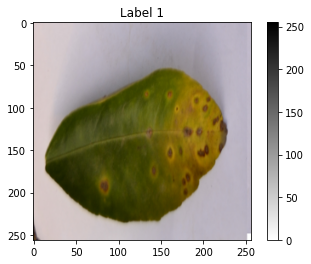

In [24]:
for image, label in training_set.take(5):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [112]:


## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "citrus_leaves",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (256, 256))
test_ds = tf.image.resize(test_ds, (256, 256))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=dataset_info.features['label'].num_classes)
test_labels = to_categorical(test_labels, num_classes=dataset_info.features['label'].num_classes)

In [26]:
print(K.image_data_format())

channels_last


### Wczytaj wytrenowany model do klasyfikacji obrazu. ###
Może to być jeden z gotowych [modeli dostępnych w Keras](https://keras.io/api/applications/). Wczytujemy go z wytrenowanymi już wcześniej wagami na Imagenecie (weights='imagenet'). 

Model możemy wczytać bez ostatnich warstw (include_top=False) i dodać je potem ręcznie, dostosowane do liczby klas w naszym zbiorze. Imagenet ma 1000 klas, my prawdopodobnie będziemy mieć ich mniej. 

Pamiętaj, żeby wyłączyć lub ograniczyć trening części modelu z wytrenowanymi już wagami (trainable=False). 

In [113]:

vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
vgg19_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [28]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Defining all functions which will be needed for the models evaluation and all analysis

In [55]:
def model_training(model):
  global model_trained, acc, val_acc, loss, val_loss, n_epoch
  # Define per-fold score containers
  # Model configuration
  batch_size = 32
  img_width, img_height, img_num_channels = 32, 32, 3
  loss_function = 'categorical_crossentropy'
  no_classes = 100
  no_epochs = 25
  optimizer = Adam()
  verbosity = 1
  num_folds = 3


  acc_per_fold = []
  loss_per_fold = []
  acc = []
  val_acc = []
  loss = []
  val_loss = []

  # Merge inputs and targets
  inputs = np.concatenate((train_ds, test_ds), axis=0)
  targets = np.concatenate((train_labels, test_labels), axis=0)

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(inputs, targets):

    # Define the model architecture


    # Compile the model
    model.compile(loss=loss_function,
                  optimizer=optimizer,
                  metrics=['accuracy'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
                validation_split=0.2, batch_size=batch_size, callbacks=[es],
                epochs=no_epochs,
                verbose=verbosity)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    model_trained = model
    n_epoch = len(history.epoch)
    #n_epochs = history.epoch
  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} -  Loss: {loss_per_fold[i]}- Accuracy: {acc_per_fold[i]}%')
    #print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [30]:
def compute_avg_CV(acc, val_acc, loss, val_loss):
  global averaged_results
  all_results = [acc, val_acc, loss, val_loss]
  averaged_results = []

  for i in range(0,4):
    averaged_results.append([sum(sub_list) / len(sub_list) for sub_list in zip(*all_results[i])])

In [31]:
def plot_acc_loss(averaged_results,model_name,n_epoch):
  acc = averaged_results[0]
  val_acc = averaged_results[1]
  loss =averaged_results[2]
  val_loss = averaged_results[3]
  epochs_range = range(n_epoch)
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.suptitle(f"Model_{model_name}", fontsize=16)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [32]:
def model_evaluation(model):
  global model_train,model_test
  
  model_train = model.evaluate(train_ds, train_labels)
  model_test = model.evaluate(test_ds, test_labels)
  print(model_train)
  print(model_test)

In [33]:
def build_model(model):
  global proper_model
  flatten_layer = layers.Flatten()
  dense_layer_1 = layers.Dense(50, activation='relu')
  dense_layer_2 = layers.Dense(20, activation='relu')
  prediction_layer = layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')


  proper_model = models.Sequential([
      
      model,
      flatten_layer,
      dense_layer_1,
      dense_layer_2,
      prediction_layer
  ])

### Zadanie 1: Wytrenuj model na swoich danych ###


## VGG19

In [114]:
build_model(vgg19_model)

In [115]:
proper_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_17 (Flatten)        (None, 32768)             0         
                                                                 
 dense_38 (Dense)            (None, 50)                1638450   
                                                                 
 dense_39 (Dense)            (None, 20)                1020      
                                                                 
 dense_40 (Dense)            (None, 4)                 84        
                                                                 
Total params: 21,663,938
Trainable params: 1,639,554
Non-trainable params: 20,024,384
_________________________________________________________________


In [116]:
model_training(proper_model)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
10/10 [==============================] - 4s 363ms/step - loss: 2.4765 - accuracy: 0.4937 - val_loss: 1.0881 - val_accuracy: 0.5250
Epoch 2/25
10/10 [==============================] - 3s 342ms/step - loss: 1.0411 - accuracy: 0.6804 - val_loss: 0.7719 - val_accuracy: 0.8000
Epoch 3/25
10/10 [==============================] - 3s 343ms/step - loss: 0.5061 - accuracy: 0.8576 - val_loss: 0.6363 - val_accuracy: 0.8375
Epoch 4/25
10/10 [==============================] - 3s 346ms/step - loss: 0.2975 - accuracy: 0.9082 - val_loss: 0.5023 - val_accuracy: 0.8375
Epoch 5/25
10/10 [==============================] - 3s 347ms/step - loss: 0.1777 - accuracy: 0.9335 - val_loss: 0.5691 - val_accuracy: 0.8750
Epoch 6/25
10/10 [==============================] - 3s 342ms/step - loss: 0.1020 - accuracy: 0.9589 - val_loss: 0.5202 - val_accuracy: 0.8375
Epoch 7/25
10/10 [==============================] -

In [117]:
model_evaluation(model_trained)

6/6 [==============================] - 2s 249ms/step - loss: 9.5239e-04 - accuracy: 1.0000
[0.009776151739060879, 0.9927884340286255]
[0.0009523903718218207, 1.0]


In [118]:
vgg_19 = [[round(num, 6) for num in model_train],[round(num, 6) for num in model_test]]

In [119]:
compute_avg_CV(acc, val_acc, loss, val_loss)

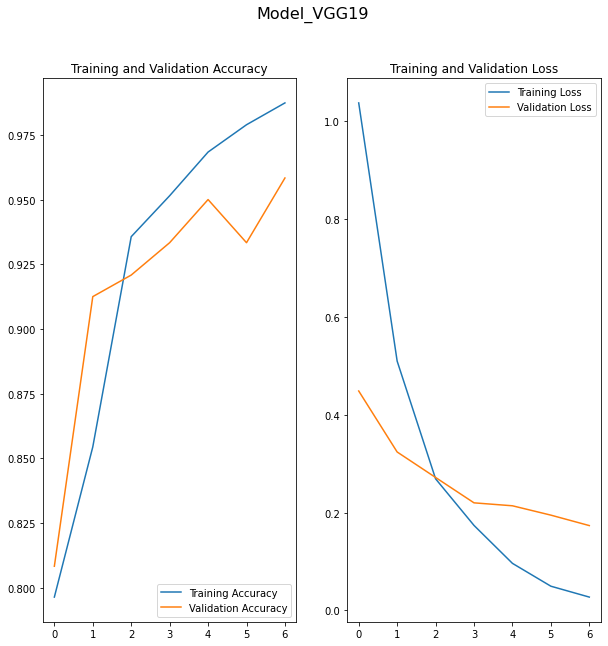

In [120]:
plot_acc_loss(averaged_results,"VGG19",n_epoch)

## VGG19 + Data Augumentation

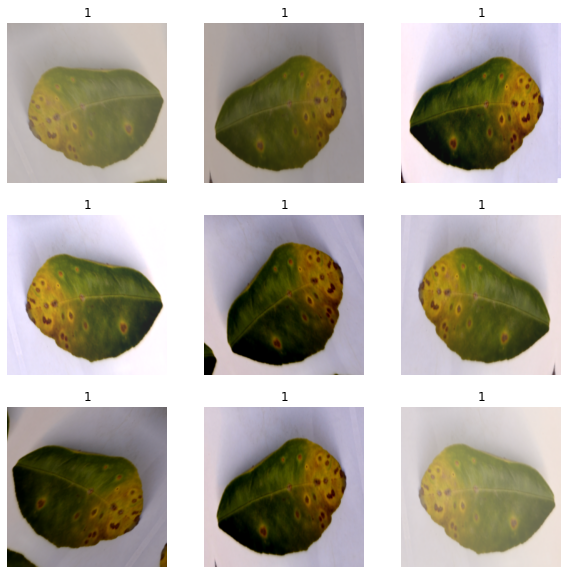

In [100]:

tf.get_logger().setLevel(logging.ERROR)
size = (256, 256)

train_ds_a = training_set.map(lambda x, y: (tf.image.resize(x, size), y))
train_ds_a = train_ds_a.cache().batch(32).prefetch(buffer_size=10)

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),layers.RandomContrast(
    0.5, seed=None),layers.RandomBrightness( 0.2, seed=None)
    ]
)


for images, labels in train_ds_a.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

train_labels = to_categorical(train_labels, num_classes=dataset_info.features['label'].num_classes)
test_labels = to_categorical(test_labels, num_classes=dataset_info.features['label'].num_classes)

In [102]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')
model_vgg19_aug = models.Sequential([
     RandomFlip("horizontal", input_shape=(256, 256, 3)),
    RandomZoom(0.2, 0.2),
    RandomRotation(0.1),layers.RandomContrast(0.5, seed=None),
    layers.RandomBrightness( 0.2, seed=None),
    vgg19_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [103]:
model_vgg19_aug.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_zoom_11 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_contrast_2 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 random_brightness_2 (Random  (None, 256, 256, 3)      0         
 Brightness)                                                     
                                                     

In [104]:
model_training(model_vgg19_aug)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
10/10 [==============================] - 15s 860ms/step - loss: 4.0784 - accuracy: 0.4177 - val_loss: 2.3282 - val_accuracy: 0.4000
Epoch 2/25
10/10 [==============================] - 5s 479ms/step - loss: 1.5864 - accuracy: 0.4304 - val_loss: 1.4085 - val_accuracy: 0.4500
Epoch 3/25
10/10 [==============================] - 5s 480ms/step - loss: 1.0649 - accuracy: 0.5032 - val_loss: 0.9530 - val_accuracy: 0.5125
Epoch 4/25
10/10 [==============================] - 5s 475ms/step - loss: 0.9799 - accuracy: 0.5570 - val_loss: 0.8488 - val_accuracy: 0.5000
Epoch 5/25
10/10 [==============================] - 5s 474ms/step - loss: 0.9137 - accuracy: 0.5127 - val_loss: 0.9159 - val_accuracy: 0.5250
Epoch 6/25
10/10 [==============================] - 5s 460ms/step - loss: 0.7873 - accuracy: 0.5918 - val_loss: 0.7691 - val_accuracy: 0.6375
Epoch 7/25
10/10 [==============================] 

In [105]:
model_evaluation(model_trained)

6/6 [==============================] - 3s 639ms/step - loss: 0.0882 - accuracy: 0.9775
[0.0913819894194603, 0.9783653616905212]
[0.08820340037345886, 0.9775280952453613]


In [106]:
vgg_19_modified = [[round(num, 6) for num in model_train],[round(num, 6) for num in model_test]]


In [107]:
compute_avg_CV(acc, val_acc, loss, val_loss)

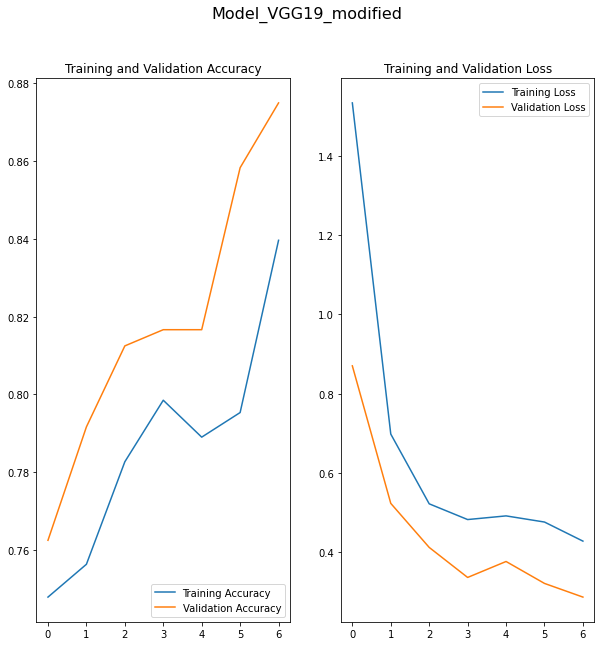

In [110]:
plot_acc_loss(averaged_results,"VGG19_modified",7)

# Comparison

- Summing up adding the data augumentation and using proper additional layers for this purpose influnced negatively on the model results based only on the evaluate scores, but is still in a good level and acceptable.
- At both approaches with the next folds the efecciency is going up.
- The scores based on the the average accuracies and losses are very similar in both models. We can notice that the loss is even better in the approach witch augumentation and lower std result- propably because of the higher number od images thanks to that.



### Zadanie 2: Dodatkowe sieci ###


## ResNet152V2




In [121]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [122]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "citrus_leaves",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (256, 256))
test_ds = tf.image.resize(test_ds, (256, 256))

train_labels = to_categorical(train_labels, num_classes=dataset_info.features['label'].num_classes)
test_labels = to_categorical(test_labels, num_classes=dataset_info.features['label'].num_classes)

In [123]:
resnet_model = ResNet152V2(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
resnet_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

234545216/234545216 [==============================] - 1s 0us/step


In [124]:
resnet_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [125]:
build_model(resnet_model)


In [126]:
proper_model.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten_18 (Flatten)        (None, 131072)            0         
                                                                 
 dense_41 (Dense)            (None, 50)                6553650   
                                                                 
 dense_42 (Dense)            (None, 20)                1020      
                                                                 
 dense_43 (Dense)            (None, 4)                 84        
                                                                 
Total params: 64,886,402
Trainable params: 6,554,754
Non-trainable params: 58,331,648
_________________________________________________________________


In [127]:
model_training(proper_model)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
10/10 [==============================] - 17s 870ms/step - loss: 4.1047 - accuracy: 0.4082 - val_loss: 0.9095 - val_accuracy: 0.7125
Epoch 2/25
10/10 [==============================] - 4s 436ms/step - loss: 0.8049 - accuracy: 0.7532 - val_loss: 1.2747 - val_accuracy: 0.7000
Epoch 3/25
10/10 [==============================] - 4s 445ms/step - loss: 0.3862 - accuracy: 0.8924 - val_loss: 0.5561 - val_accuracy: 0.8625
Epoch 4/25
10/10 [==============================] - 4s 445ms/step - loss: 0.1140 - accuracy: 0.9652 - val_loss: 0.4492 - val_accuracy: 0.9000
Epoch 5/25
10/10 [==============================] - 4s 444ms/step - loss: 0.0480 - accuracy: 0.9873 - val_loss: 0.4018 - val_accuracy: 0.9250
Epoch 6/25
10/10 [==============================] - 4s 436ms/step - loss: 0.0243 - accuracy: 0.9905 - val_loss: 0.3525 - val_accuracy: 0.9250
Epoch 7/25
10/10 [==============================] 

In [128]:
model_evaluation(model_trained)

6/6 [==============================] - 3s 479ms/step - loss: 0.1012 - accuracy: 0.9888
[0.04450881481170654, 0.995192289352417]
[0.10116726160049438, 0.9887640476226807]


In [129]:
resnet = [[round(num, 6) for num in model_train],[round(num, 6) for num in model_test]]

In [130]:
compute_avg_CV(acc, val_acc, loss, val_loss)

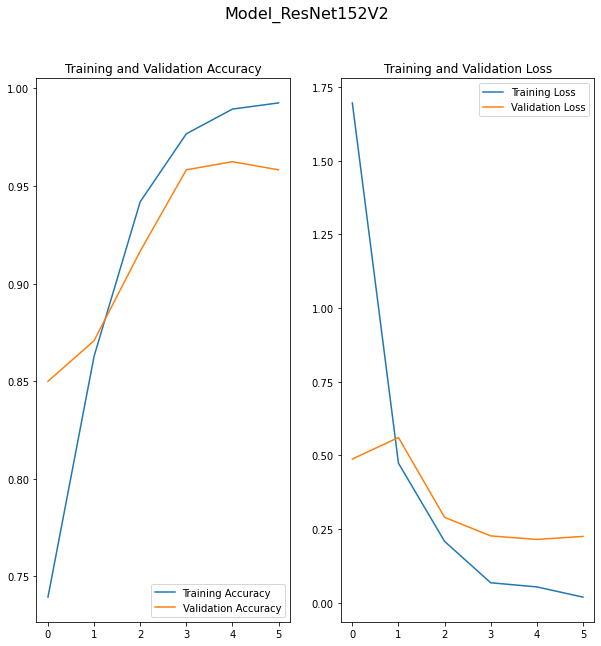

In [131]:
plot_acc_loss(averaged_results,"ResNet152V2",n_epoch)

## EfficientNetB5

In [151]:
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input

In [152]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "citrus_leaves",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (256, 256))
test_ds = tf.image.resize(test_ds, (256, 256))

train_labels = to_categorical(train_labels, num_classes=dataset_info.features['label'].num_classes)
test_labels = to_categorical(test_labels, num_classes=dataset_info.features['label'].num_classes)

In [153]:
efficient_model = EfficientNetB5(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
efficient_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [154]:
efficient_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [155]:
build_model(efficient_model)

In [156]:
proper_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 8, 8, 2048)       28513527  
                                                                 
 flatten_20 (Flatten)        (None, 131072)            0         
                                                                 
 dense_47 (Dense)            (None, 50)                6553650   
                                                                 
 dense_48 (Dense)            (None, 20)                1020      
                                                                 
 dense_49 (Dense)            (None, 4)                 84        
                                                                 
Total params: 35,068,281
Trainable params: 6,554,754
Non-trainable params: 28,513,527
_________________________________________________________________


In [157]:
model_training(proper_model)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
10/10 [==============================] - 19s 684ms/step - loss: 10.2714 - accuracy: 0.3861 - val_loss: 6.6886 - val_accuracy: 0.5125
Epoch 2/25
10/10 [==============================] - 3s 357ms/step - loss: 3.1854 - accuracy: 0.6709 - val_loss: 1.5770 - val_accuracy: 0.7250
Epoch 3/25
10/10 [==============================] - 4s 359ms/step - loss: 0.9022 - accuracy: 0.8038 - val_loss: 0.5283 - val_accuracy: 0.8750
Epoch 4/25
10/10 [==============================] - 4s 360ms/step - loss: 0.2469 - accuracy: 0.9241 - val_loss: 0.2314 - val_accuracy: 0.9250
Epoch 5/25
10/10 [==============================] - 4s 359ms/step - loss: 0.1387 - accuracy: 0.9525 - val_loss: 0.2302 - val_accuracy: 0.9625
Epoch 6/25
10/10 [==============================] - 3s 355ms/step - loss: 0.1155 - accuracy: 0.9715 - val_loss: 0.2281 - val_accuracy: 0.9625
Epoch 7/25
10/10 [==============================]

In [158]:
model_evaluation(model_trained)

6/6 [==============================] - 2s 250ms/step - loss: 0.0155 - accuracy: 0.9888
[0.008969200775027275, 0.995192289352417]
[0.015505647286772728, 0.9887640476226807]


In [159]:
efficient = [[round(num, 6) for num in model_train],[round(num, 6) for num in model_test]]

In [160]:
compute_avg_CV(acc, val_acc, loss, val_loss)

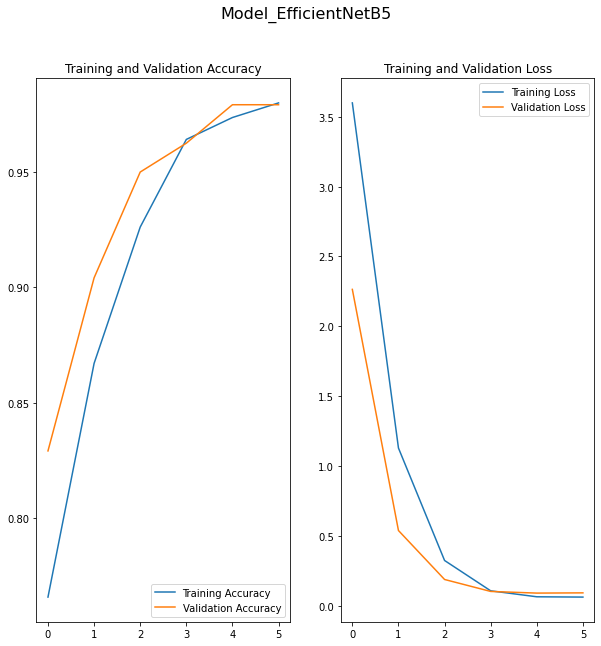

In [161]:
plot_acc_loss(averaged_results,"EfficientNetB5",n_epoch)

## Comparison

- We can see a jump in the function flow at the beginning of the workout in loss and accuracy results in the Resnet model
- The flow od the funtion in EfficientNet model is going very smooth and in the good direction
- The EfficieNet has also better results, in the second fold accuracy on the test set had 100%.

### Zadanie 3: Trening od zera i porównanie ###


In [86]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "citrus_leaves",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (256, 256))
test_ds = tf.image.resize(test_ds, (256, 256))

train_labels = to_categorical(train_labels, num_classes=dataset_info.features['label'].num_classes)
test_labels = to_categorical(test_labels, num_classes=dataset_info.features['label'].num_classes)

In [87]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "citrus_leaves",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (256, 256))
test_ds = tf.image.resize(test_ds, (256, 256))

train_labels = to_categorical(train_labels, num_classes=dataset_info.features['label'].num_classes)
test_labels = to_categorical(test_labels, num_classes=dataset_info.features['label'].num_classes)

## Building "own model"

In [88]:
train_ds[0].shape

TensorShape([256, 256, 3])

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Flatten,ZeroPadding2D, ZeroPadding3D,GlobalAveragePooling2D, Activation, AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [90]:

model_ = Sequential([
    #RandomFlip("horizontal", input_shape=(256, 256, 3)),
    #RandomZoom(0.2, 0.2),
    RandomFlip("horizontal", input_shape=(256, 256, 3)),
    RandomZoom(0.2, 0.2),
    #Activation('relu',input_shape=(256, 256, 3)),
    #ZeroPadding2D(padding=(4), data_format=None),
    #AveragePooling2D(input_shape = (48, 48, 3)),
    Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'),
    #BatchNormalization(),
    ZeroPadding2D(padding=(4), data_format=None),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    #BatchNormalization(),
    ZeroPadding2D(padding=(4), data_format=None),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    #BatchNormalization(),
    ZeroPadding2D(padding=(4), data_format=None),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    #BatchNormalization(),
    ZeroPadding2D(padding=(4), data_format=None),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    #BatchNormalization(),
    ZeroPadding2D(padding=(4), data_format=None),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    
    #BatchNormalization(),
    ZeroPadding2D(padding=(4), data_format=None),
    MaxPooling2D(pool_size=(2,2)),
  
  
    
    
])



## Preprocessing input
#train_ds = preprocess_input(train_ds) 
#test_ds = preprocess_input(test_ds)

In [91]:
model_.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_9 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_zoom_9 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_138 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 conv2d_139 (Conv2D)         (None, 256, 256, 16)      2320      
                                                                 
 zero_padding2d_69 (ZeroPadd  (None, 264, 264, 16)     0         
 ing2D)                                                          
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 132, 132, 16)     0         
 g2D)                                                

In [92]:
flatten_layer = layers.Flatten()
#dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')


own_model = models.Sequential([
      
      model_,
      flatten_layer,
      #dense_layer_1,
      dense_layer_2,
      prediction_layer
  ])

In [93]:
own_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 11, 11, 256)       1252624   
                                                                 
 flatten_15 (Flatten)        (None, 30976)             0         
                                                                 
 dense_33 (Dense)            (None, 128)               3965056   
                                                                 
 dense_34 (Dense)            (None, 4)                 516       
                                                                 
Total params: 5,218,196
Trainable params: 5,218,196
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_training(own_model)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
10/10 [==============================] - 3s 174ms/step - loss: 2.1927 - accuracy: 0.2943 - val_loss: 1.3621 - val_accuracy: 0.4500
Epoch 2/25
10/10 [==============================] - 1s 147ms/step - loss: 1.3506 - accuracy: 0.3608 - val_loss: 1.3199 - val_accuracy: 0.3250
Epoch 3/25
10/10 [==============================] - 1s 149ms/step - loss: 1.3327 - accuracy: 0.3481 - val_loss: 1.3289 - val_accuracy: 0.3250
Epoch 4/25
10/10 [==============================] - 1s 148ms/step - loss: 1.3045 - accuracy: 0.3481 - val_loss: 1.2841 - val_accuracy: 0.3250
Epoch 5/25
10/10 [==============================] - 1s 148ms/step - loss: 1.2154 - accuracy: 0.4019 - val_loss: 1.2081 - val_accuracy: 0.4125
Epoch 6/25
10/10 [==============================] - 1s 149ms/step - loss: 1.1176 - accuracy: 0.4684 - val_loss: 1.1981 - val_accuracy: 0.3625
Score for fold 1: loss of 1.1938577890396118; accur

In [95]:
model_evaluation(model_trained)

6/6 [==============================] - 1s 142ms/step - loss: 0.7420 - accuracy: 0.6517
[0.6494883298873901, 0.6658653616905212]
[0.7420384883880615, 0.6516854166984558]


In [96]:
own = [[round(num, 6) for num in model_train],[round(num, 6) for num in model_test]]

In [97]:
compute_avg_CV(acc, val_acc, loss, val_loss)

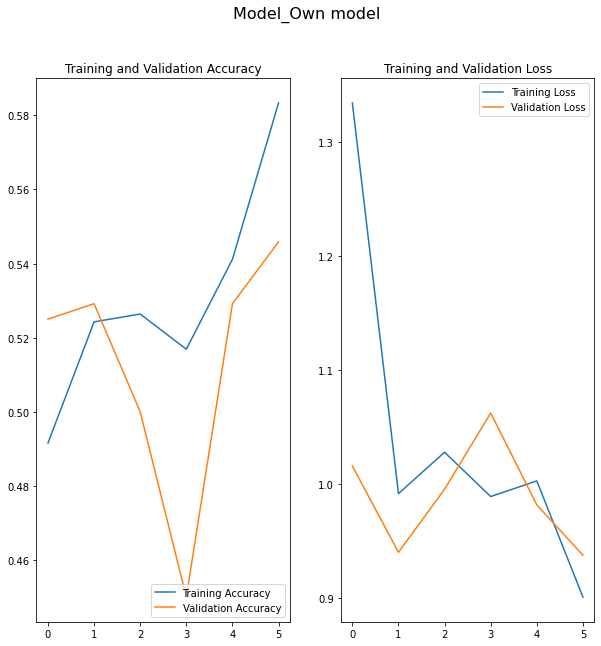

In [99]:
plot_acc_loss(averaged_results,"Own model",6)

- Second and third fold were similar in the results.
- In the epochs the way of model behaving was varied.
- Definitely that model is not accable for tasks of classifications.

# Summary

In [173]:
final_table = pd.DataFrame([[vgg_19[0],vgg_19[1]],[vgg_19_modified[0],vgg_19_modified[1]],[resnet[0],resnet[1]],
             [efficient[0],efficient[1]] ,[own[0],own[1]]]).T
final_table.columns = ['Vgg_19', 'Vgg_19_modified', 'ResNet152V2', 'EfficientNetB5','Model_Own']
final_table.index = ['train_sample', 'test_sample']



In [174]:
final_table

,Vgg_19,Vgg_19_modified,ResNet152V2,EfficientNetB5,Model_Own
train_sample,"[0.009776, 0.992788]","[0.091382, 0.978365]","[0.044509, 0.995192]","[0.008969, 0.995192]","[0.649488, 0.665865]"
test_sample,"[0.000952, 1.0]","[0.088203, 0.977528]","[0.101167, 0.988764]","[0.015506, 0.988764]","[0.742038, 0.651685]"


- In the table above are presented the results of all model evaluations from 5 approaches. First value is related to the loss, and the second to the accuracy.
- All the 4 models imported from Keras show genereal high results of classification efficiency.
- The best one is the Vgg_19 model, which network architecture complexity is the simplest. The modifications based on data augmentation had negative impact on the results.
- Model_own is characterized by incomparably worse results, the all loss are close or even higher than the accuracy in the test_sample. There is a chance, that without Earlystopping the result would be more stable and the efficienty would rise (the trend of plots was going properly).
